<a href="https://colab.research.google.com/github/AnnLivio/PySpark/blob/main/The_Notebook_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Welcome To the Notebook**


### **Task 1 - Loading our data**

Installing the pyspark using pip

In [1]:
!pip install pyspark

Importing Modules

In [2]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px

# pandas module
import pandas as pd

# pyspark SQL functions
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [3]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Loading our data

In [4]:
data = spark.read.csv("/content/dataset.csv", header=True, inferSchema=True)
data.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Print the data schema to check out the data types

In [5]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension

In [6]:
data.count(), len(data.columns)

(7043, 21)

### **Task 2 - Exploratory Data Analysis**
- Distribution Analysis
- Correlation Analysis
- Univariate Analysis
- Finding Missing values

Let's define some lists to store different column names with different data types.

In [7]:
numerical_cols = [name for name, dtype in data.dtypes if dtype == 'int' or dtype == 'double']
categorical_cols = [name for name, dtype in data.dtypes if dtype == 'string']

data.select(numerical_cols).describe().show()

+-------+------------------+------------------+------------------+
|summary|            tenure|    MonthlyCharges|      TotalCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7043|              7032|
|   mean|32.435751810308105| 64.76169246059922|2283.3004408418697|
| stddev| 25.07522813150339|30.090047097678482| 2266.771361883145|
|    min|                 0|             18.25|              18.8|
|    max|               458|            118.75|            8684.8|
+-------+------------------+------------------+------------------+



In [9]:
categorical_cols.remove('customerID')
categorical_cols.remove('gender')
categorical_cols

['SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

Let's get all the numerical features and store them into a pandas dataframe.

In [10]:
df = data.select(numerical_cols).toPandas()
df.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Let's create histograms to analyse the distribution of our numerical columns.

<ipython-input-11-1e84376a4827>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax, bins=20)


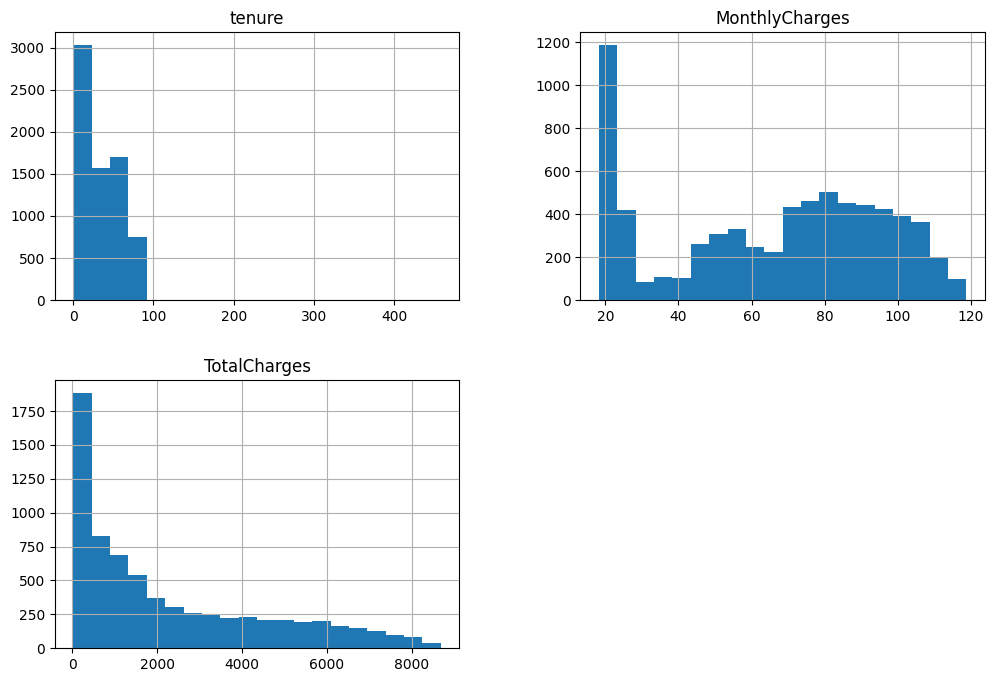

In [11]:
fig = plt.figure(figsize=(12, 8))
ax =fig.gca()
df.hist(ax=ax, bins=20)
plt.show()

Let's generate the correlation matrix

In [12]:
df.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


Let's check the unique value count per each categorical variables

In [13]:
for col_name in categorical_cols[1:]:
  data.groupBy(col_name).count().show()

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682|
|         Yes| 6361|
+------------+-----+

+----------------+-----+
|   MultipleLines|count|
+----------------+-----+
|No phone service|  682|
|              No| 3390|
|             Yes| 2971|
+----------------+-----+

+---------------+-----+
|InternetService|count|
+---------------+-----+
|    Fiber optic| 3096|
|             No| 1526|
|            DSL| 2421|
+---------------+-----+

+-------------------+-----+
|     OnlineSecurity|count|
+-------------------+-----+
|                 No| 3498|
|                Yes| 2019|
|No internet service| 1526|
+-------------------+-----+

+-------------------+-----+
|       OnlineBackup|count|
+-------------------+-----+
|                 No| 3088|
|      

Let's find number of null values in all of our dataframe columns

In [14]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

### **Task 3 - Data Preprocessing**
- Handling the missing values
- Removing the outliers

**Handling the missing values** <br>
Let's create a list of column names with missing values

In [15]:
cols_with_missing_values = [name for name, dtype in data.dtypes if dtype != 'string' and data.filter(col(name).isNull()).count() > 0]
cols_with_missing_values

['TotalCharges']

Creating our Imputer

In [16]:
imputer = Imputer(
    inputCols=cols_with_missing_values,
    outputCols=cols_with_missing_values
).setStrategy('mean')

Use Imputer to fill the missing values

In [17]:
imputer = imputer.fit(data)
data =  imputer.transform(data)

Let's check the missing value counts again

In [18]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100

In [19]:
data.select('*').filter(col('tenure') > 100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

Let's drop the outlier row

In [20]:
data = data.filter(col('tenure') < 100)

### **Task 4 - Feature Preparation**
- Numerical Features
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>
To apply our machine learning model we need to combine all of our numerical and categorical features into vectors. For now let's create a feature vector for our numerical columns.


In [21]:
numerical_vector_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_features')
data = numerical_vector_assembler.transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn| numerical_features|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL| 

**Numerical Scaling** <br>
Let's standardize all of our numerical features.

In [22]:
scaler = StandardScaler(inputCol='numerical_features', outputCol='scaled_numerical_features', withStd=True, withMean=True)
scaler = scaler.fit(data)
data = scaler.transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn| numerical_features|scaled_numerical_features|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------+-------------------------+
|7590-VHVEG|Female|         

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [23]:
#Create a list of outputCols
categorical_cols_indexed = [name + '_Indexed' for name in categorical_cols]

#Create a StringIndexer
string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=categorical_cols_indexed)
data = string_indexer.fit(data).transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------+-------------------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn| numerical_features|scaled_numerical_features|SeniorCitizen_Inde

Let's combine all of our categorifal features in to one feature vector.

In [24]:
categorical_cols_indexed.remove('Churn_Indexed')
categorical_vector_assembler = VectorAssembler(inputCols=categorical_cols_indexed, outputCol='categorical_features')
data = categorical_vector_assembler.transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------+-------------------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn| numerical_features|scaled_numerical_featur

Now let's combine categorical and numerical feature vectors.

In [25]:
final_vector_assembler = VectorAssembler(inputCols=['scaled_numerical_features', 'categorical_features'], outputCol='final_feature_vector')
data = final_vector_assembler.transform(data)
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------+-------------------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+--------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn| numerical_features|sc

In [26]:
data.select(['final_feature_vector','Churn_Indexed']).show()

+--------------------+-------------+
|final_feature_vector|Churn_Indexed|
+--------------------+-------------+
|(18,[0,1,2,4,6,7,...|          0.0|
|(18,[0,1,2,8,9,11...|          0.0|
|(18,[0,1,2,8,9,10...|          1.0|
|[0.51406079695460...|          0.0|
|(18,[0,1,2],[-1.2...|          1.0|
|(18,[0,1,2,7,11,1...|          1.0|
|(18,[0,1,2,5,7,10...|          0.0|
|(18,[0,1,2,6,7,8,...|          0.0|
|(18,[0,1,2,4,7,11...|          1.0|
|(18,[0,1,2,5,8,9,...|          0.0|
|(18,[0,1,2,4,5,8,...|          0.0|
|[-0.6667820073655...|          0.0|
|[1.04340412302915...|          0.0|
|(18,[0,1,2,7,10,1...|          1.0|
|(18,[0,1,2,9,11,1...|          0.0|
|[1.49131001432301...|          0.0|
|[0.79909181868705...|          0.0|
|[1.57274744910371...|          0.0|
|(18,[0,1,2,4,5,8,...|          1.0|
|(18,[0,1,2,10,11,...|          0.0|
+--------------------+-------------+
only showing top 20 rows



### **Task 5 - Model Training**
- Train and Test data splitting
- Creating our model
- Training our model
- Make initial predictions using our model

In this task, we are going to start training our model

In [27]:
train, test = data.randomSplit([0.7, 0.3], seed=100)
train.count(), test.count()

(4930, 2112)

Now let's create and train our desicion tree

In [28]:
dt = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = 'Churn_Indexed', maxDepth=6)
model = dt.fit(train)

Let's make predictions on our test data

In [29]:
predictions = model.transform(test)
predictions.select('Churn_Indexed', 'prediction').show()

+-------------+----------+
|Churn_Indexed|prediction|
+-------------+----------+
|          1.0|       1.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          1.0|       1.0|
|          0.0|       0.0|
|          1.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          1.0|       0.0|
|          0.0|       0.0|
|          0.0|       1.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
+-------------+----------+
only showing top 20 rows



### **Task 6 - Model Evaluation**
- Calculating area under the ROC curve for the `test` set
- Calculating area under the ROC curve for the `training` set
- Hyper parameter tuning

In [30]:
evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
auc_test = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
auc_test

0.7805634737671788

Let's get the AUC for our `training` set

In [31]:
predictions_train = model.transform(train)
auc_train = evaluator.evaluate(predictions_train, {evaluator.metricName: "areaUnderROC"})
auc_train

0.78225816874655

**Hyper parameter tuning**

Let's find the best `maxDepth` parameter for our DT model.

In [32]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = 'Churn_Indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

In [33]:
# params = maxDepth possible values
params = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
test_accuracies, train_accuracies = evaluate_dt(params)
print(test_accuracies)
print(train_accuracies)

[0.7918744332963926, 0.7678230877272001, 0.6938514510575503, 0.5664944085244075, 0.7805634737671788, 0.7440200546405987, 0.7521183603079311, 0.7413318794113986, 0.7560771368800336, 0.7673252774995704, 0.7643579729641636, 0.7449149277878855, 0.7281944304517627, 0.7167839088770231, 0.7093896491030527, 0.7024120090791103, 0.7032114685994346, 0.6921796383764276, 0.6884733227054801]
[0.7737711024910238, 0.7721112330375414, 0.6732017750857608, 0.5647403286677019, 0.78225816874655, 0.7592292910830459, 0.7620815565520909, 0.7870332770211113, 0.8234614964486611, 0.8585796437154058, 0.8826864723922799, 0.9206509439940764, 0.9370405523044929, 0.9471451704625996, 0.9617035545075071, 0.9697875617252553, 0.9763898292789089, 0.981161706410421, 0.9835664064519465]


Let's visualize our results

In [34]:
df = pd.DataFrame({'maxDepth': params, 'test_accuracies': test_accuracies, 'train_accuracies': train_accuracies})
df.head()

,maxDepth,test_accuracies,train_accuracies
0,2,0.791874,0.773771
1,3,0.767823,0.772111
2,4,0.693851,0.673202
3,5,0.566494,0.564740
4,6,0.780563,0.782258


In [35]:
px.line(df, x='maxDepth', y=['test_accuracies', 'train_accuracies'], title='Hyperparameter Tuning')

We can observe that the best value for maxDepth is 6. We go back to the task where we create the DecissionTree and we change the value of maxDepth from 3 to 6. The accuracy is gonna improve from 0.76 to 0.79

### **7 - Model Deployment**
- Giving Recommendations using our model



We were asked to recommend a solution to reduce the customer churn.


In [42]:
feature_importance = model.featureImportances
scores = [score for i, score in enumerate(feature_importance)]
df = pd.DataFrame(scores, columns=['score'], index= categorical_cols_indexed + numerical_cols)
df.head(20)

,score
SeniorCitizen_Indexed,0.206889
Partner_Indexed,0.013945
Dependents_Indexed,0.005064
PhoneService_Indexed,0.005096
MultipleLines_Indexed,0.000000
InternetService_Indexed,0.005235
OnlineSecurity_Indexed,0.013753
OnlineBackup_Indexed,0.018998
DeviceProtection_Indexed,0.146645
TechSupport_Indexed,0.033883


In [43]:
px.bar(df, y='score', title='Feature Importance')

Let's create a bar chart to visualize the customer churn per contract type

In [40]:
df = data.groupBy(['Contract', 'Churn']).count().toPandas()
px.bar(df, x='Contract', y='count', color='Churn')

The bar chart displays the number of churned customers based on their contract type. It is evident that customers with a "Month-to-month" contract have a higher churn rate compared to those with "One year" or "Two year" contracts. As a recommendation, the telecommunication company could consider offering incentives or discounts to encourage customers with month-to-month contracts to switch to longer-term contracts.

In [44]:
spark.stop()